# Objekte für den 24.05.2010


In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from standard_config import *
import sys
sys.path.append("{}/utils/tracking".format(local_home_path))
import object_tracking as ot
import segmentation as oseg

import fixed_colourbar as fc

import glob
import tqdm 

from plotting_tools.colormaps import enhanced_colormap
emap = enhanced_colormap(vmin=210,vmed=240,vmax=300)

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
data_path = "{}/SEVIRI".format(local_data_path)

In [3]:
sat_files = glob.glob("{}/*.nc".format(data_path))

In [4]:
import MSGtools as mst
from mpl_toolkit

In [5]:
slon,slat = mst.get_msg_lon_lat('eu')

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


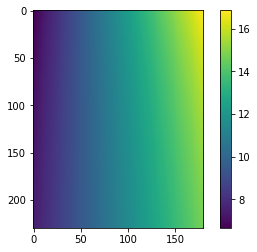

In [11]:
plt.imshow(slon[40:270,450:630])
plt.colorbar()

In [42]:
rmin,rmax,cmin,cmax = (60,270,420,630)

In [20]:
slon.shape

(600, 800)

In [43]:
#objects = []
sat_data = {'ir108':[],'wv073':[]}#,'hrv':[]}
for sf in tqdm.tqdm(sorted(sat_files)):
    sd = xr.open_dataset(sf)
    
    ir108 = sd.IR_108.data[0][rmin:rmax,cmin:cmax]
    wv073 = sd.WV_073.data[0][rmin:rmax,cmin:cmax]
    #hrv = sd.HRV.data[0]#[90*3:255*3,300*3:640*3]
    
    sat_data['ir108'].append(ir108)
    sat_data['wv073'].append(wv073)
    #sat_data['hrv'].append(hrv)
    
    #obj = oseg.watershed_local_min_segmentation(ir108,4,220,273.15,240,5,0.5)
    #objects.append(obj)
    
    sd.close()

100%|██████████| 288/288 [00:05<00:00, 48.96it/s]


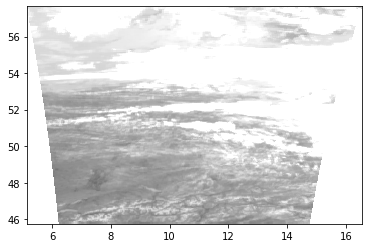

In [44]:
plt.pcolormesh(slon[60:270,420:630],slat[60:270,420:630],sat_data['ir108'][144],vmin=270,vmax=330,cmap='gray_r')

In [47]:
sat_files = sorted(sat_files)

In [48]:
case_objects, tracks = ot.track_objects_lmin_cost(sat_data,
                                                  data_field='ir108',
                                                  flow_field='wv073',
                                                  minimum_depth=7,
                                                  tmin=220,tmax=273.15,tlevel=240,spread=5,
                                                  search_factor=3,smoothing_factor=0)

In [65]:
%matplotlib inline

In [29]:
objects = {i:{} for i in np.arange(170,180)}
n_objects = {i:{} for i in np.arange(170,180)}
object_area = {i:{} for i in np.arange(170,180)}

In [30]:
for i in np.arange(170,180):
    for d in np.arange(1,11):
        obj = oseg.watershed_local_min_segmentation(sat_data['ir108'][i],d,273.15,240,5,0)
        objects[i][d] = obj
        n_objects[i][d] = np.max(np.unique(obj))

        area = []

        for oid in np.unique(obj)[1:]:
            area.append(len(np.where(obj==oid)[0]))

        object_area[i][d] = area

KeyboardInterrupt: 

In [143]:
object_area

{170: {1: [274,
   62,
   80,
   17,
   20,
   32,
   53,
   94,
   129,
   8,
   159,
   72,
   196,
   11,
   133,
   73,
   93,
   229,
   18,
   26,
   23,
   63,
   16,
   141,
   129,
   32,
   76,
   16,
   29,
   239,
   41,
   54,
   12,
   8,
   91,
   24,
   26,
   90,
   32,
   129,
   20,
   81,
   54,
   62,
   52,
   10,
   32,
   150,
   18,
   105,
   123,
   520,
   44,
   16,
   17,
   26,
   9,
   91,
   591,
   15,
   29,
   54,
   34,
   1,
   28,
   45,
   38,
   11,
   57,
   21,
   47,
   12,
   52,
   16,
   7,
   8,
   28,
   7,
   6,
   11,
   26,
   31,
   11,
   21,
   19,
   18,
   175,
   8,
   41,
   394,
   11,
   16,
   21,
   16,
   37,
   51,
   45,
   527,
   16,
   14,
   16,
   41,
   19,
   26,
   46,
   12,
   32,
   62,
   109,
   340,
   236,
   40,
   256,
   85,
   11,
   10,
   27,
   31,
   50,
   23,
   50,
   29,
   18,
   64,
   21,
   30,
   52,
   74,
   19,
   99,
   129,
   35,
   41,
   720,
   46,
   14,
   10,
   13,
   37,
   2

NameError: name 'objects' is not defined

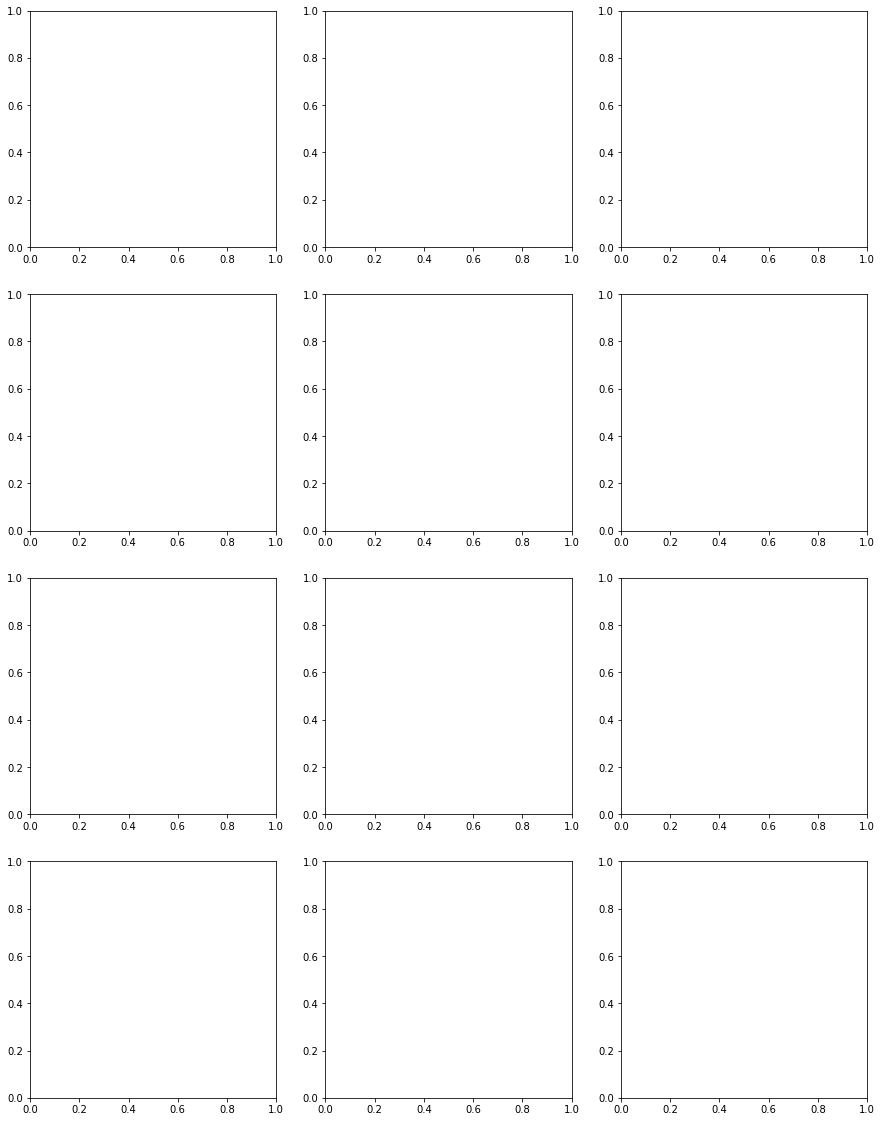

In [28]:
fig,ax = plt.subplots(4,3,figsize=(15,20))
axs  =ax.ravel()

for i,d in enumerate(list(objects.keys())):
    axs[i].imshow(sat_data['ir108'][174],vmin=210,vmax=300,cmap='gray_r')
    axs[i].imshow(np.ma.masked_less(objects[d],1),vmin=1,vmax=np.max(objects[d]),cmap='nipy_spectral')
    axs[i].set_title(u"d = {} K, Objekte: {},\nmittl. Objektfläche = {:.2f} km²".format(d, n_objects[d],np.mean(object_area[d])*21))


In [145]:
mean_area = {i:[] for i in np.arange(170,180)}

for i in np.arange(170,180):
    mean_area[i] = [np.mean(object_area[i][k])*21 for k in object_area[i].keys()]

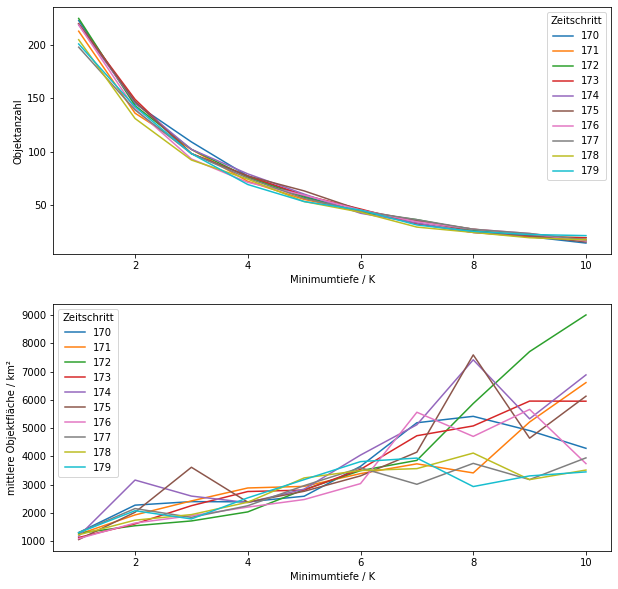

In [150]:
fig,ax = plt.subplots(2,1,figsize=(10,10))
for i in np.arange(170,180):
    ax[0].plot(list(n_objects[i].keys()),list(n_objects[i].values()),label=i)
    ax[1].plot(list(n_objects[i].keys()),mean_area[i], label=i)
ax[0].set_xlabel("Minimumtiefe / K")
ax[0].set_ylabel("Objektanzahl")
ax[0].legend(title="Zeitschritt")

#ax[1].plot(list(n_objects.keys()),mean_area)
ax[1].set_xlabel("Minimumtiefe / K")
ax[1].set_ylabel(u"mittlere Objektfläche / km²")
ax[1].legend(title="Zeitschritt")

In [151]:
divmod(170*5,60)

(14, 10)

In [100]:
from scipy.optimize import curve_fit

In [130]:
params, params_cov = curve_fit(lambda t,a,b: a*np.exp(b*t),  list(n_objects.keys()),list(n_objects.values()))

In [131]:
yy = [params[0] * np.exp(params[1] * x) for x in np.arange(1,10.01,0.01)]

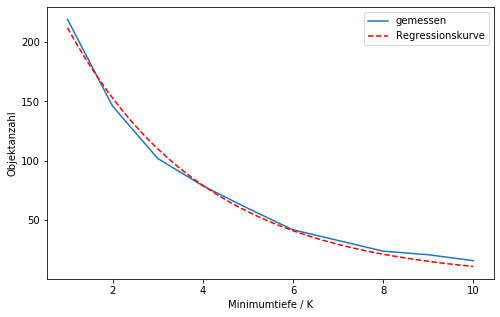

In [132]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(list(n_objects.keys()),list(n_objects.values()),label="gemessen")
ax.plot(np.arange(1,10.01,0.01), yy, 'r--', label="Regressionskurve")
ax.set_xlabel("Minimumtiefe / K")
ax.set_ylabel("Objektanzahl")
ax.legend()

In [61]:
(14*60 + 30) / 5

174.0

In [49]:
sd = xr.open_dataset(sf)

In [50]:
slon = sd.lon.data[rmin:rmax,cmin:cmax]
slat = sd.lat.data[rmin:rmax,cmin:cmax]

In [51]:
def write_object2netcdf(object_data, time_data, lon_data, lat_data, filename):
    """
    Write segmentation to a netCDF file.

    Inputs:
        * object_data: array-like, in
            numpy arrays with object labels
        * time_data: array_like
            times of the time steps in the object data
        * lon_data: array-like, 2d
            longitudes of the pixels in the object data
        * lat_data: array-like, 2d
            latitudes of the pixels in the object data
        * filename: string
            name of the file to write the data to
    """
    # create file skeleton
    ds = xr.Dataset({'object_mask':(['time','x','y'], object_data)},
                     coords={'time': time_data,
                            'lon': (['x', 'y'], lon_data),
                            'lat': (['x', 'y'], lat_data)})

    # add object attributes
    ds['object_mask'].attrs['units'] = 1
    ds['object_mask'].attrs['summary'] = "object mask"
    #ds['time'].attrs['units'] = 'minutes since 2010-05-24T00:00:00'

    # set file attributes
    ds.attrs['title'] = "Object mask"
    ds.attrs['institution'] = "Leibniz Institute for Tropospheric Research"
    ds.attrs['contact_person'] = "Stephan Lenk, lenk@tropos.de"
    ds.attrs['processing_time'] = pd.Timestamp.now().strftime("%Y%m%dT%H:%M:%S")
    ds.attrs['author'] = "Stephan Lenk, lenk@tropos.de"
    ds.attrs['license'] = "For non-commercial use only."
    ds.attrs['source'] = "MSG SEVIRI data"
    ds.attrs['history'] = "Compilation of data into NetCDF4 file"
    ds.attrs['summary'] = "Object mask"
    ds.attrs['region_id'] = "de"
    ds.attrs['spatial_resolution'] = "3 km x 3km"
    ds.attrs['gdal_projection'] = u'+proj=geos +h=35785831 +lon_0=9.5 +sweep=y'
   

    encoding = {'object_mask':{'complevel':9,'zlib':True},#,'dtype':'int32','scale_factor':0.000001,'_FillValue':-999},
                'lon':{'complevel':9,'zlib':True},#,'dtype':'int32','scale_factor':0.000001,'_FillValue':-999},
                'lat':{'complevel':9,'zlib':True}#,'dtype':'int32','scale_factor':0.000001,'_FillValue':-999}
               }
    # write file
    ds.to_netcdf(filename,encoding=encoding)
    ds.close()

    return 

In [52]:
def save_list2json(save_list,file_name):
    import json
    
    with open(file_name, "w") as write_file:
        json.dump(save_list, write_file)
        
def read_json2list(file_name):
    import json
    
    with open(file_name, "r") as read_file:
        data = json.load(read_file)

    return data

In [53]:
track_file_target = "{}/object_tracks_20100524_de_7K.json".format(local_data_path)

In [54]:
save_list2json(tracks,track_file_target)

In [55]:
t = pd.date_range(start="20100524T0000",
                  end="20100524T2355",
                  freq="5min")

In [58]:
time_range = t.values.astype('int64') // 10**9

In [41]:
plt.switch_backend("Agg")
for i, ir in tqdm.tqdm(enumerate(sat_data['ir108']),total=len(sat_data['ir108'])):
    fig,ax = plt.subplots(1,1,figsize=(16,10))
    ax.imshow(ir,vmin=210,vmax=300,cmap=emap)
    ax.set_title("{}".format(t[i].strftime("%d.%m.%Y %H:%M UTC")))
    plt.savefig("/vols/satellite/home/lenk/pics/20100425/{}.png".format(t[i].strftime("%Y%d%mT%H%M")),bbox_inches="tight")
    plt.close()

 14%|█▎        | 39/288 [00:16<01:48,  2.29it/s]

KeyboardInterrupt: 

<Figure size 1152x720 with 0 Axes>

In [56]:
object_file_target = "{}/objektmaske_20100524_de_7K.nc".format(local_data_path)

In [59]:
write_object2netcdf(case_objects,
                    time_range,
                    slon,slat,object_file_target)

In [57]:
case_objects = xr.open_dataset("/vols/satellite/home/lenk/data/objektmaske_20100524_de.nc",decode_cf=False)

In [162]:
#case_objects.close()

AttributeError: 'list' object has no attribute 'close'

In [58]:
plt.switch_backend("Agg")
for i, om in tqdm.tqdm(enumerate(case_objects.object_mask.data),total=len(case_objects.object_mask.data)):
    fig,ax = plt.subplots(1,1,figsize=(16,10))
    ax.imshow(sat_data['ir108'][i],vmin=210,vmax=300,cmap='gray_r')
    ax.contour(om,np.unique(om)[1:],cmap='nipy_spectral')
    ax.set_title("IR-10,8-µm-Kanal und Objektmaske, {}".format(t[i].strftime("%d.%m.%Y %H:%M UTC")))
    plt.savefig("/vols/satellite/home/lenk/pics/20100425/objektmaske_{}.png".format(t[i].strftime("%Y%d%mT%H%M")),bbox_inches="tight")
    plt.close()



  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 1/288 [00:01<05:37,  1.18s/it]

  1%|          | 2/288 [00:02<05:16,  1.11s/it]

  1%|          | 3/288 [00:03<05:03,  1.07s/it]

  1%|▏         | 4/288 [00:04<04:57,  1.05s/it]

  2%|▏         | 5/288 [00:05<04:55,  1.04s/it]

  2%|▏         | 6/288 [00:06<04:54,  1.04s/it]

  2%|▏         | 7/288 [00:07<05:01,  1.07s/it]

  3%|▎         | 8/288 [00:09<06:27,  1.38s/it]

  3%|▎         | 9/288 [00:10<06:11,  1.33s/it]

  3%|▎         | 10/288 [00:11<06:11,  1.33s/it]

  4%|▍         | 11/288 [00:13<06:14,  1.35s/it]

  4%|▍         | 12/288 [00:14<06:02,  1.32s/it]

  5%|▍         | 13/288 [00:15<05:38,  1.23s/it]

  5%|▍         | 14/288 [00:16<05:19,  1.17s/it]

  5%|▌         | 15/288 [00:18<05:58,  1.31s/it]

  6%|▌         | 16/288 [00:19<06:17,  1.39s/it]

  6%|▌         | 17/288 [00:20<05:53,  1.30s/it]

  6%|▋         | 18/288 [00:22<05:29,  1.22s/it]

  7%|▋         | 19/288 [00:22<05:09,  1.15s/it]

  7%|▋         |

100%|██████████| 288/288 [04:57<00:00,  1.03s/it]


In [52]:
case_objects.object_mask[0]

<xarray.DataArray 'object_mask' (x: 210, y: 180)>
array([[       0,        0,        0, ...,        0,        0,        0],
       [       0,        0,        0, ...,        0,        0,        0],
       [       0, 15000000,        0, ...,        0,        0,        0],
       ...,
       [       0,        0,        0, ...,        0,        0,        0],
       [       0,        0,        0, ...,        0,        0,        0],
       [       0,        0,        0, ...,        0,        0,        0]],
      dtype=int32)
Coordinates:
    time     int64 1274659200
Dimensions without coordinates: x, y
Attributes:
    _FillValue:    -999
    units:         1
    summary:       object mask
    coordinates:   lon lat
    scale_factor:  1e-06

In [8]:
%matplotlib inline

KeyError: 'ir108'

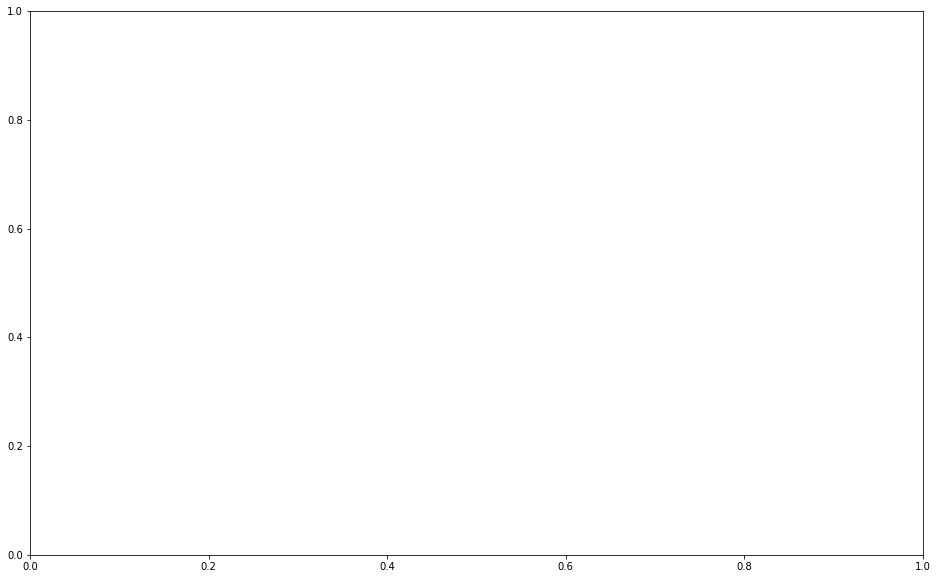

In [15]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
p = ax.imshow(sd['ir108']['0235'] - sd['ir108']['0230'],vmin=-20,vmax=20,cmap='RdBu_r')
ax.set_title("IR-10,8-µm von 2:35 UTC - IR-10,8-µm von 2:30 UT")
fc.colourbar(p)

Die unterschiede zwischen den Zeitpunkten sind nicht sehr groß und wahrscheinlich hauptsächlich auf die Bewegung der Wolken zurückzuführen.

In [10]:
from skimage import feature, filters, measure, morphology
from scipy import ndimage as ndi

import sys
sys.path.append("/vols/satellite/home/lenk/utils/tracking")
import object_tracking as ot
import segmentation as oseg

Manchmal werden die Objekt plötzlich größer und dann wieder kleiner. Irgendwas geht da schief. Das müssen wir uns mal genauer ansehen.

In [16]:
def time2index(time,dt=5):
    h = int(time[0:2])
    m = int(time[2:4])
    
    return int((h*60 + m) / dt)

def time_index2time_string(time_index,dt):
    (h,m) = divmod(time_index*dt,60)
    
    return "{:02d}:{:02d}".format(int(h),int(m))

In [12]:
time_steps = ['0025','0030','0525','0530']

In [16]:
tidx = [time2index(ts) for ts in time_steps]

In [17]:
sd = {'ir108':{ts:[] for ts in time_steps}}

In [18]:
for its,ts in enumerate(time_steps):
    sd['ir108'][ts] = sat_data['ir108'][tidx[its]]

In [19]:
sd

{'ir108': {'0025': array([[267.85763513, 268.19166396, 268.02480845, ..., 277.07548486,
          277.37759182, 277.52828851],
         [268.35820337, 266.84782399, 265.65465882, ..., 276.77241925,
          277.07548486, 277.52828851],
         [268.35820337, 267.35419107, 265.65465882, ..., 276.6205242 ,
          276.6205242 , 276.6205242 ],
         ...,
         [277.37759182, 277.52828851, 279.17057934, ..., 279.90798989,
          280.20140569, 279.31850772],
         [280.63989419, 280.49394813, 280.9311406 , ..., 279.466212  ,
          279.76095211, 279.90798989],
         [279.02242585, 277.67874879, 277.97896435, ..., 278.7254396 ,
          278.87404627, 278.87404627]]),
  '0030': array([[262.86313907, 265.99725103, 267.85763513, ..., 276.92407244,
          277.52828851, 277.82897372],
         [263.3936264 , 266.168037  , 266.50859815, ..., 276.6205242 ,
          276.92407244, 277.22665763],
         [266.33848542, 267.35419107, 266.84782399, ..., 276.6205242 ,
        

In [20]:
time_steps = [time_index2time_string(t,5) for t in np.arange(0,289)]

In [21]:
time_steps

['00:00',
 '00:05',
 '00:10',
 '00:15',
 '00:20',
 '00:25',
 '00:30',
 '00:35',
 '00:40',
 '00:45',
 '00:50',
 '00:55',
 '01:00',
 '01:05',
 '01:10',
 '01:15',
 '01:20',
 '01:25',
 '01:30',
 '01:35',
 '01:40',
 '01:45',
 '01:50',
 '01:55',
 '02:00',
 '02:05',
 '02:10',
 '02:15',
 '02:20',
 '02:25',
 '02:30',
 '02:35',
 '02:40',
 '02:45',
 '02:50',
 '02:55',
 '03:00',
 '03:05',
 '03:10',
 '03:15',
 '03:20',
 '03:25',
 '03:30',
 '03:35',
 '03:40',
 '03:45',
 '03:50',
 '03:55',
 '04:00',
 '04:05',
 '04:10',
 '04:15',
 '04:20',
 '04:25',
 '04:30',
 '04:35',
 '04:40',
 '04:45',
 '04:50',
 '04:55',
 '05:00',
 '05:05',
 '05:10',
 '05:15',
 '05:20',
 '05:25',
 '05:30',
 '05:35',
 '05:40',
 '05:45',
 '05:50',
 '05:55',
 '06:00',
 '06:05',
 '06:10',
 '06:15',
 '06:20',
 '06:25',
 '06:30',
 '06:35',
 '06:40',
 '06:45',
 '06:50',
 '06:55',
 '07:00',
 '07:05',
 '07:10',
 '07:15',
 '07:20',
 '07:25',
 '07:30',
 '07:35',
 '07:40',
 '07:45',
 '07:50',
 '07:55',
 '08:00',
 '08:05',
 '08:10',
 '08:15',


In [22]:
sd_smooth = {ts:[] for ts in time_steps}
lmins = {ts:[] for ts in time_steps}
masks = {ts:[] for ts in time_steps}
mask_values = {'threshold': {ts:[] for ts in time_steps},
               'value':{ts:[] for ts in time_steps}} 

In [23]:
for i,ts in enumerate(time_steps):
    sd = sat_data['ir108'][i]
    #sm = filters.gaussian(sd['ir108'][ts],0)
    sm = filters.gaussian(sd,0)
    sd_smooth[ts] = sm
    
    # find local minima
    local_mins = morphology.h_minima(sm, 6)
    
    # label the local minima
    lmins_labeled = ndi.label(local_mins)[0]
    
    lmins[ts] = lmins_labeled
    
    lmin_properties = oseg.get_lmin_properties(lmins_labeled,sd)
    
#     thresh_map = np.zeros_like(sd['ir108'][ts])
#     value_map = np.zeros_like(sd['ir108'][ts])
    thresh_map = np.zeros_like(sd)
    value_map = np.zeros_like(sd)
    
    for lm in np.unique(lmins_labeled)[1:]:
        loc = np.where(lmins_labeled == lm)
               
        thresh_map[loc] = lmin_properties[lm]['threshold']
        value_map[loc] = lmin_properties[lm]['value']
        
    mask_values['threshold'][ts] = thresh_map
    mask_values['value'][ts] = value_map
        
    # get mask with possible object locations
    #mask = oseg.create_mask_from_thresholds(lmins_labeled,lmin_properties,sd['ir108'][ts])
    mask = oseg.watershed_local_min_segmentation(sd,6,220,273.15,240,5,0)
    masks[ts] = mask

IndexError: list index out of range

In [25]:
sat_data

{'ir108': [array([[262.68555971, 261.61204721, 266.50859815, ..., 275.24239833,
          274.62336077, 274.46795887],
         [252.66740989, 252.86880981, 259.79116597, ..., 276.6205242 ,
          276.46838616, 276.16337667],
         [244.80030066, 244.12287561, 245.47122265, ..., 276.77241925,
          276.77241925, 276.77241925],
         ...,
         [276.92407244, 277.22665763, 279.17057934, ..., 279.31850772,
          279.76095211, 280.20140569],
         [280.63989419, 280.49394813, 281.22153219, ..., 279.466212  ,
          280.20140569, 280.34778561],
         [279.466212  , 278.12872173, 278.42754094, ..., 279.02242585,
          279.17057934, 279.76095211]]),
  array([[268.85594183, 267.35419107, 263.74543105, ..., 276.6205242 ,
          276.01050294, 275.85738169],
         [263.3936264 , 259.23686756, 254.06613433, ..., 276.92407244,
          276.31600403, 276.31600403],
         [252.46547229, 249.78948368, 247.87825464, ..., 276.92407244,
          276.77241925, 

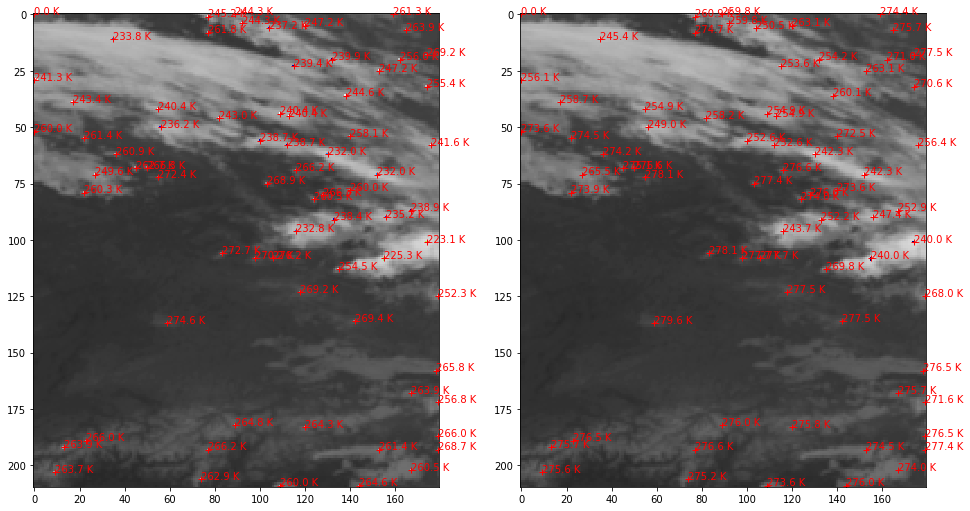

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(sat_data['ir108'][30//5],vmin=210,vmax=300,cmap='gray_r')
ax[0].imshow(np.ma.masked_less(mask_values['value']['00:30'],100),vmin=210,vmax=300,cmap=emap)
for i,lm in enumerate(np.unique(lmins['00:30'])):
    lm_loc = np.where(lmins['00:30'] == lm)
    ax[0].plot(np.min(lm_loc[1]),
               np.min(lm_loc[0]),'r+')
    ax[0].text(np.min(lm_loc[1]),
               np.min(lm_loc[0]),
               "{:.1f} K".format(np.unique(mask_values['value']['00:30'][lm_loc])[0]),c='r')
    
ax[1].imshow(sat_data['ir108'][30//5],vmin=210,vmax=300,cmap='gray_r')
ax[1].imshow(np.ma.masked_less(mask_values['threshold']['00:30'],100),vmin=210,vmax=300,cmap=emap)
for i,lm in enumerate(np.unique(lmins['00:30'])):
    lm_loc = np.where(lmins['00:30'] == lm)
    ax[1].plot(np.min(lm_loc[1]),
               np.min(lm_loc[0]),'r+')
    ax[1].text(np.min(lm_loc[1]),
               np.min(lm_loc[0]),
               "{:.1f} K".format(np.unique(mask_values['threshold']['00:30'][lm_loc])[0]),c='r')
    

In [28]:
mask = oseg.watershed_local_min_segmentation(sat_data['ir108'][time2index("0030",5)],6,220,273.15,240,6,0)

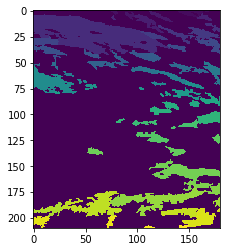

In [29]:
plt.imshow(mask)

IndexError: index 4 is out of bounds for axis 0 with size 4

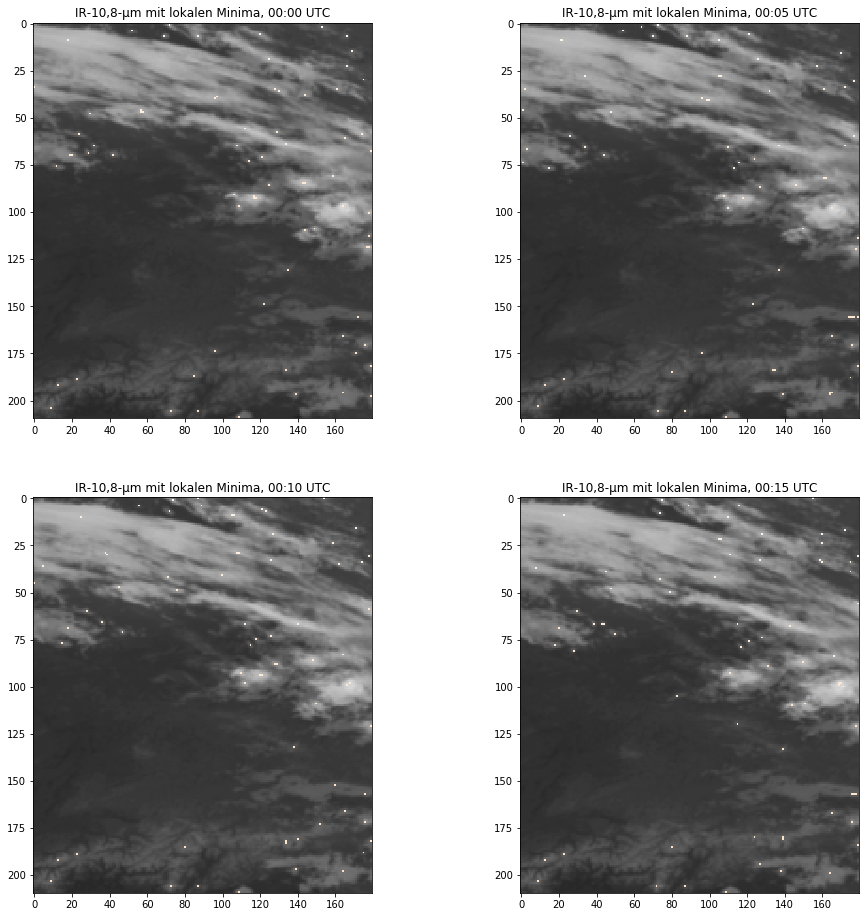

In [31]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
axs = ax.ravel()

for i,ts in enumerate(sd_smooth.keys()):
    axs[i].imshow(sd_smooth[ts],vmin=210,vmax=300,cmap='gray_r')
    axs[i].imshow(np.ma.masked_less(lmins[ts],1),vmin=0,vmax=421,cmap='Oranges')
    axs[i].set_title("IR-10,8-µm mit lokalen Minima, {} UTC".format(ts))

IndexError: index 4 is out of bounds for axis 0 with size 4

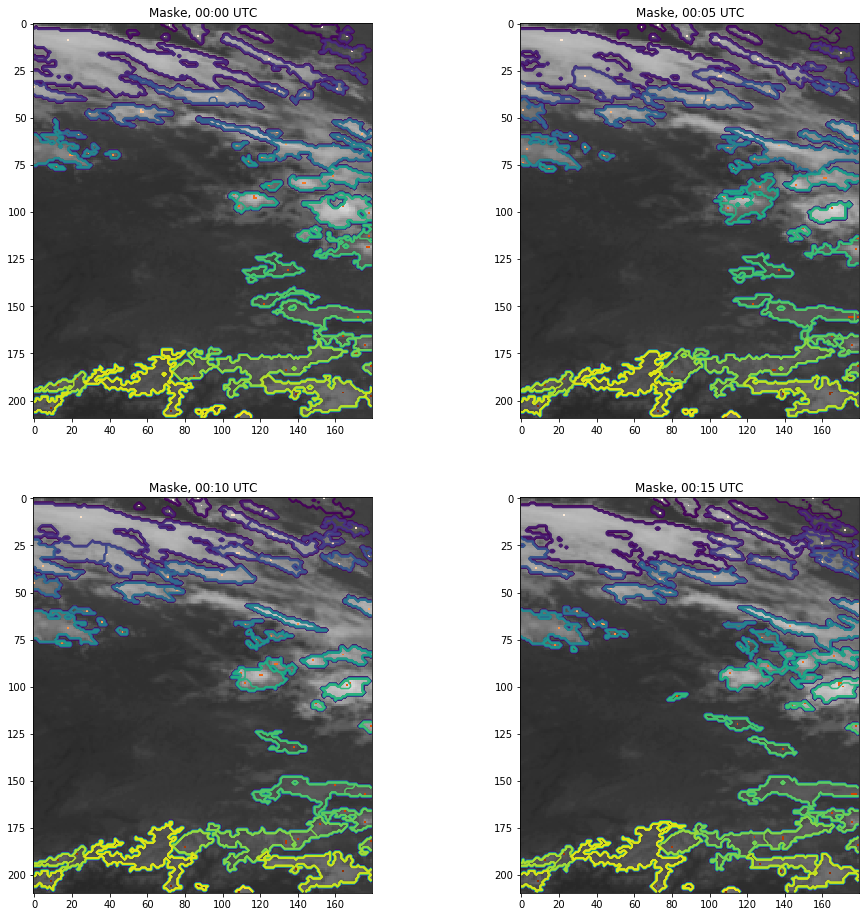

In [32]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
axs = ax.ravel()

for i,ts in enumerate(sd_smooth.keys()):
    axs[i].imshow(sat_data['ir108'][i],vmin=210,vmax=300,cmap='gray_r')
    #axs[i].imshow(np.ma.masked_less(masks[ts],1),alpha=0.7,cmap='nipy_spectral')
    axs[i].contour(masks[ts],np.unique(masks[ts]))
    axs[i].imshow(np.ma.masked_less(lmins[ts],1),vmin=1,vmax=np.max(lmins[ts]),cmap='Oranges')
    axs[i].set_title("Maske, {} UTC".format(ts))

In [33]:
oids = {}
for lm in np.unique(lmins['0525'])[1:]:
    lm_loc = np.where(lmins['0525']==lm)
    
    oids[lm] = np.unique(masks['0525'][lm_loc])

KeyError: '0525'

In [24]:
oids

{1: array([1], dtype=int32),
 2: array([2], dtype=int32),
 3: array([3], dtype=int32),
 4: array([4], dtype=int32),
 5: array([5], dtype=int32),
 6: array([6], dtype=int32),
 7: array([7], dtype=int32),
 8: array([8], dtype=int32),
 9: array([9], dtype=int32),
 10: array([10], dtype=int32),
 11: array([11], dtype=int32),
 12: array([12], dtype=int32),
 13: array([13], dtype=int32),
 14: array([14], dtype=int32),
 15: array([15], dtype=int32),
 16: array([16], dtype=int32),
 17: array([17], dtype=int32),
 18: array([18], dtype=int32),
 19: array([19], dtype=int32),
 20: array([20], dtype=int32),
 21: array([21], dtype=int32),
 22: array([22], dtype=int32),
 23: array([23], dtype=int32),
 24: array([24], dtype=int32),
 25: array([25], dtype=int32),
 26: array([26], dtype=int32),
 27: array([27], dtype=int32),
 28: array([28], dtype=int32),
 29: array([29], dtype=int32),
 30: array([30], dtype=int32),
 31: array([31], dtype=int32),
 32: array([32], dtype=int32),
 33: array([33], dtype=int

In [52]:
ts = '0525'

In [53]:
sm = filters.gaussian(sd['ir108'][ts],0)
sd_smooth[ts] = sm

# find local minima
local_mins = morphology.h_minima(sm, 6)

# label the local minima
lmins_labeled = ndi.label(local_mins)[0]

lmins[ts] = lmins_labeled

lmin_properties = oseg.get_lmin_properties(lmins_labeled,sd['ir108'][ts])

thresh_map = np.zeros_like(sd['ir108'][ts])
value_map = np.zeros_like(sd['ir108'][ts])

for lm in np.unique(lmins_labeled)[1:]:
    loc = np.where(lmins_labeled == lm)

    thresh_map[loc] = lmin_properties[lm]['threshold']
    value_map[loc] = lmin_properties[lm]['value']

mask_values['threshold'][ts] = thresh_map
mask_values['value'][ts] = value_map        

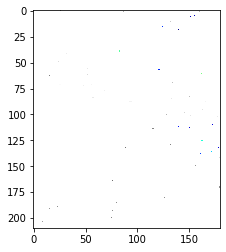

In [54]:
plt.imshow(np.ma.masked_less(mask_values['value'][ts],180),vmin=210,vmax=300,cmap=emap)

Hier liegt das Problem. Beim Zeitschritt 05:30 UTC wird die Maske aberwitzig groß

In [235]:
data_array = sd['ir108']['0530']

In [247]:
label_masks = [ ]

for label in lmin_properties.keys():
    # mask where data values are below threshold
    mask = np.zeros_like(lmins_labeled)
    mask = np.ma.masked_where(data_array < lmin_properties[label]['threshold'],mask)

    # label those areas
    m_labeled = ndi.label(mask.mask*1)[0]
    min_label = m_labeled[lmin_properties[label]['column'],lmin_properties[label]['row']]

    # select that area, where the local minimum is located inside
    omask = np.full_like(data_array,0)#False)
    omask[np.where(m_labeled==min_label)] = label #True

    # append to list of maksk
    label_masks.append(omask)

# combine masks
label_mask =  np.ma.masked_greater(np.sum(label_masks,axis=0),0).mask

In [287]:
label = 10

In [288]:
mask = np.zeros_like(lmins_labeled)

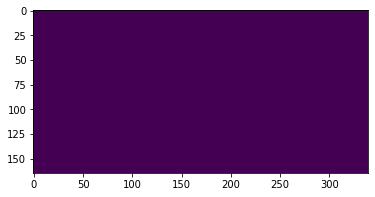

In [289]:
plt.imshow(mask)

In [290]:
mask = np.ma.masked_where(data_array < lmin_properties[label]['threshold'],mask)

In [296]:
fig,ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(sd['ir108']['0530'])
ax.imshow(mask*1)
ax.plot(lmin_properties[label]['row'],lmin_properties[label]['column'],'r+')

In [297]:
sd['ir108']['0530'][lmin_properties[label]['row'],lmin_properties[label]['column']]

284.64209693663224

In [298]:
lmin_properties

{1: {'value': 265.31069345200444,
  'threshold': 276.2562792117888,
  'column': 0,
  'row': 47},
 2: {'value': 247.87825464414084,
  'threshold': 263.75639999791747,
  'column': 0,
  'row': 163},
 3: {'value': 227.70868933396656, 'threshold': 240, 'column': 9, 'row': 236},
 4: {'value': 262.8631390705421,
  'threshold': 275.19132055636317,
  'column': 10,
  'row': 123},
 5: {'value': 247.44660339856824,
  'threshold': 263.30180470634707,
  'column': 11,
  'row': 185},
 6: {'value': 248.3073371573005,
  'threshold': 264.2013412731977,
  'column': 19,
  'row': 176},
 7: {'value': 275.5503920273609,
  'threshold': 280.5503920273609,
  'column': 28,
  'row': 11},
 8: {'value': 228.2930668606832, 'threshold': 240, 'column': 30, 'row': 339},
 9: {'value': 227.11840893819425, 'threshold': 240, 'column': 34, 'row': 316},
 10: {'value': 279.4662119951843,
  'threshold': 284.4662119951843,
  'column': 38,
  'row': 127},
 11: {'value': 246.35595642851317,
  'threshold': 262.121947530232,
  'colum

In [35]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.morphology import h_minima

In [43]:
@interact
def plot_object_definitions(t = (0,288),
                            depth=(0,20),
                            spread=(0,25),
                            t_min=(180,240),
                            t_max=(240,300),
                            t_level=(200,270),
                            s_factor=(0,10)):
    case_object = oseg.watershed_local_min_segmentation(
                    sat_data['ir108'][t],
                    depth=depth,
                    tmin=t_min,
                    tmax=t_max,
                    tlevel=t_level,
                    spread=spread,
                    smoothing_factor=s_factor,
    )
    
    lmins = h_minima(sat_data['ir108'][t],depth)
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.imshow(sat_data['ir108'][t],vmin=210,vmax=300,cmap='gray_r')
    ax.contour(case_object,np.unique(case_object)[1:],cmap='Greens')    
    ax.imshow(np.ma.masked_less(lmins,1),alpha=0.8,cmap='Blues')

interactive(children=(IntSlider(value=144, description='t', max=288), IntSlider(value=10, description='depth',…

In [ ]:
# label those areas
m_labeled = ndi.label(mask.mask*1)[0]
min_label = m_labeled[lmin_properties[label]['column'],lmin_properties[label]['row']]

In [273]:
omask = np.full_like(data_array,0)#False)
omask[np.where(m_labeled==min_label)] = label #True

In [275]:
omask

array([[10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       ...,
       [ 0.,  0.,  0., ..., 10., 10., 10.],
       [ 0.,  0.,  0., ..., 10., 10., 10.],
       [ 0.,  0.,  0., ..., 10., 10., 10.]])

In [330]:
from PIL import Image

In [345]:
ir.shape

(165, 340)

In [31]:
270-60

210

In [32]:
630-450

180

In [33]:
for i,ir in enumerate(sat_data['ir108']):
    fig,ax = plt.subplots(1,1,figsize=(1.8,2.1))
    ax.imshow(ir,vmin=210,vmax=300,cmap=emap)
    ax.axis('off')
    ax.margins(0,0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(0,0,1,1,0,0)
    plt.margins(0,0)
    plt.savefig("/vols/satellite/home/lenk/pics/20100425/tracking/ir108_{}.png".format(t[i].strftime("%Y%m%d_%H%M")),
                pad_inches=0,bbox_inches="tight",dpi=100)
    plt.close()

In [331]:
ir = sat_data['ir108'][0]

In [332]:
img = Image.fromarray(ir)

In [336]:
ir

array([[281.07644279, 281.07644279, 280.9311406 , ..., 275.70401178,
        275.08802201, 274.15637544],
       [281.36640969, 281.07644279, 281.07644279, ..., 275.39652127,
        275.70401178, 275.39652127],
       [282.08764994, 282.08764994, 282.08764994, ..., 276.01050294,
        275.85738169, 275.39652127],
       ...,
       [283.37293687, 283.23093447, 283.37293687, ..., 268.69034064,
        267.69014228, 267.18572919],
       [283.23093447, 283.37293687, 283.37293687, ..., 267.69014228,
        267.35419107, 267.01694077],
       [282.80372472, 282.66091786, 282.66091786, ..., 266.84782399,
        265.65465882, 264.4446693 ]])

In [ ]:
for d in tqdm.tqdm(np.arange(5,11)):
    case_objects, tracks = ot.track_objects_lmin_cost(sat_data,
                                                  data_field='ir108',
                                                  flow_field='wv073',
                                                  minimum_depth=d,
                                                  tmin=220,tmax=273.15,tlevel=240,spread=5,
                                                  search_factor=3,smoothing_factor=0)
    
    track_file_target = "{}/object_tracks_20100524_de_{:02d}K.json".format(local_data_path,d)
    save_list2json(tracks,track_file_target)
    
    object_file_target = "{}/objektmaske_20100524_de_{:02d}K.nc".format(local_data_path,d)
    write_object2netcdf(case_objects,
                    time_range,
                    slon,slat,object_file_target)